# Finanz-Ticketdaten erkunden und vorverarbeiten

### Benötigte Pakete importieren und Einstellungen setzen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import json
import re
import string
import spacy

from nltk.corpus import stopwords
from langdetect import detect
from wordcloud import WordCloud

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

### Ticketdaten einlesen und Spaltenbezeichnungen anpassen

In [3]:
finance_ticket_df = pd.read_excel('finance_tickets_cleaned_with_topics_kaggle.xlsx')
finance_ticket_df

,Unnamed: 0,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
0,0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,0
1,1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx tell agent upgrad...,xxxx card tell agent date information order up...,117,card tell agent date information order upgrad...,1
2,2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,81,card report application submit identity consen...,1
3,3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,429,try book ticket come offer apply ticket card i...,1
4,4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,163,son check deposit chase account fund bank acco...,0
...,...,...,...,...,...,...,...
21067,21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,232,chase card customer decade offer solicitation ...,1
21068,21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas xxxx credit card provider claim purc...,702,call chas credit card provider claim purchase...,3
21069,21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,695,pay risk consumer chase bank chase year trust ...,3
21070,21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,563,flawless credit chase credit card chase freedo...,4


In [4]:
ticket_df = finance_ticket_df[['complaint_what_happened', 'Topic']].copy()
ticket_df.rename(columns={'complaint_what_happened': 'Meldung', 'Topic': 'Ticketart'}, inplace=True)  
ticket_df

,Meldung,Ticketart
0,Good morning my name is XXXX XXXX and I apprec...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
2,Chase Card was reported on XX/XX/2019. However...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",1
4,my grand son give me check for {$1600.00} i de...,0
...,...,...
21067,After being a Chase Card customer for well ove...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",3
21069,I am not familiar with XXXX pay and did not un...,3
21070,I have had flawless credit for 30 yrs. I've ha...,4


### Allgemeine Informationen über das DataFrame ansehen

In [5]:
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Meldung    21072 non-null  object
 1   Ticketart  21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


### Alle leere Zeilen löschen

In [6]:
ticket_df.Meldung.replace(r'', np.nan, regex=True, inplace=True)
ticket_df = ticket_df[ticket_df.Meldung.notna()]

In [7]:
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Meldung    21072 non-null  object
 1   Ticketart  21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 493.9+ KB


### Funktion zur Textbereinigung definieren

In [8]:
def clean_tickets(text):
    
    if text is None: # Text is None abfangen
        return ''
    
    text = str(text)
    
    text = re.sub('_x000D_', '', text) # _x000D_ entfernen --- entsteht in Excel durch den ASCII-Code für Line Feed?
    
    text = re.sub('XXXX', '', text) # Anonymisierungen komplett entfernen
    
    text = re.sub('XX', '', text) # Anonymisierungen komplett entfernen
    
    text = re.sub('https?:\/\/\S*', '', text) # URLs entfernen
    
    text = re.sub('\d+', '', text) # Zahlen entfernen
    
    for c in string.punctuation:
        text = text.replace(c, ' ') # Die Zeichen ---> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~ <--- entfernen
    
    text = re.sub('Ä', 'Ae', text) # Umlaute umwandeln  
    text = re.sub('ä', 'ae', text)
    text = re.sub('Ö', 'Oe', text)
    text = re.sub('ö', 'oe', text)
    text = re.sub('Ü', 'Ue', text)
    text = re.sub('ü', 'ue', text)
    text = re.sub('ß', 'ss', text)
    
    text = re.sub(' \w ', ' ', text) # Alleinstehende Zeichen entfernen
        
    text = re.sub('\n', ' ', text) # Zeilenumbrüche entfernen --- \n, \t, \r sind Escape Character
    
    text = re.sub('\r', ' ', text) # Carriage Returns entfernen
    
    text = re.sub('\t', ' ', text) # Tabulatoren entfernen
    
    text = re.sub(' +', ' ', text).strip() # Whitespace entfernen
    
    text = text.encode('ascii', 'ignore').decode() # Text in ASCII umwandeln
    
    text = text.lower()

    return text

### Funktionen zur Stopp-Wort-Entfernung definieren

In [9]:
english_stop_words = stopwords.words('english')

def remove_stop_words(text):
    tokens = text.split()
    return ' '.join([t for t in tokens if not t in english_stop_words])

### Funktion zur Lemmatisierung definieren

In [10]:
nlp = spacy.load('en_core_web_sm')

In [11]:
def lemmatize_text_spacy(text):
    spacy_doc = nlp(text)
    lemmatize_tokens = [token.lemma_ for token in spacy_doc] # token.text, token.pos_, token.dep_, token.lemma_
    lemmatize_text = ' '.join(lemmatize_tokens)
    return lemmatize_text

### Neu indizieren und Zwischeninformationen ansehen

In [12]:
ticket_df.reset_index(drop=True, inplace=True)
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Meldung    21072 non-null  object
 1   Ticketart  21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


### Meldung_cleaned, Meldung_BERT setzen

In [13]:
ticket_df['Meldung_cleaned'] = ''
ticket_df['Meldung_BERT'] = ''

for index, row in ticket_df.iterrows():
    try:
        meldung = row['Meldung']
        meldung_cleaned = clean_tickets(meldung)
    except:
        ticket_df.at[index, 'Meldung_cleaned'] = ''
        ticket_df.at[index, 'Meldung_BERT'] = ''
    else:
        ticket_df.at[index, 'Meldung_cleaned'] = meldung_cleaned
        ticket_df.at[index, 'Meldung_BERT'] = meldung_cleaned

### Ticketlängen setzen und Histogramm ausgeben

In [14]:
ticket_df['Länge'] = 0

for index, row in ticket_df.iterrows():
    try:
        length = len(row['Meldung_cleaned'].split())
    except:
        ticket_df.at[index, 'Länge'] = 0
    else:
        ticket_df.at[index, 'Länge'] = length
        
ticket_df = ticket_df[ticket_df.Länge > 0]

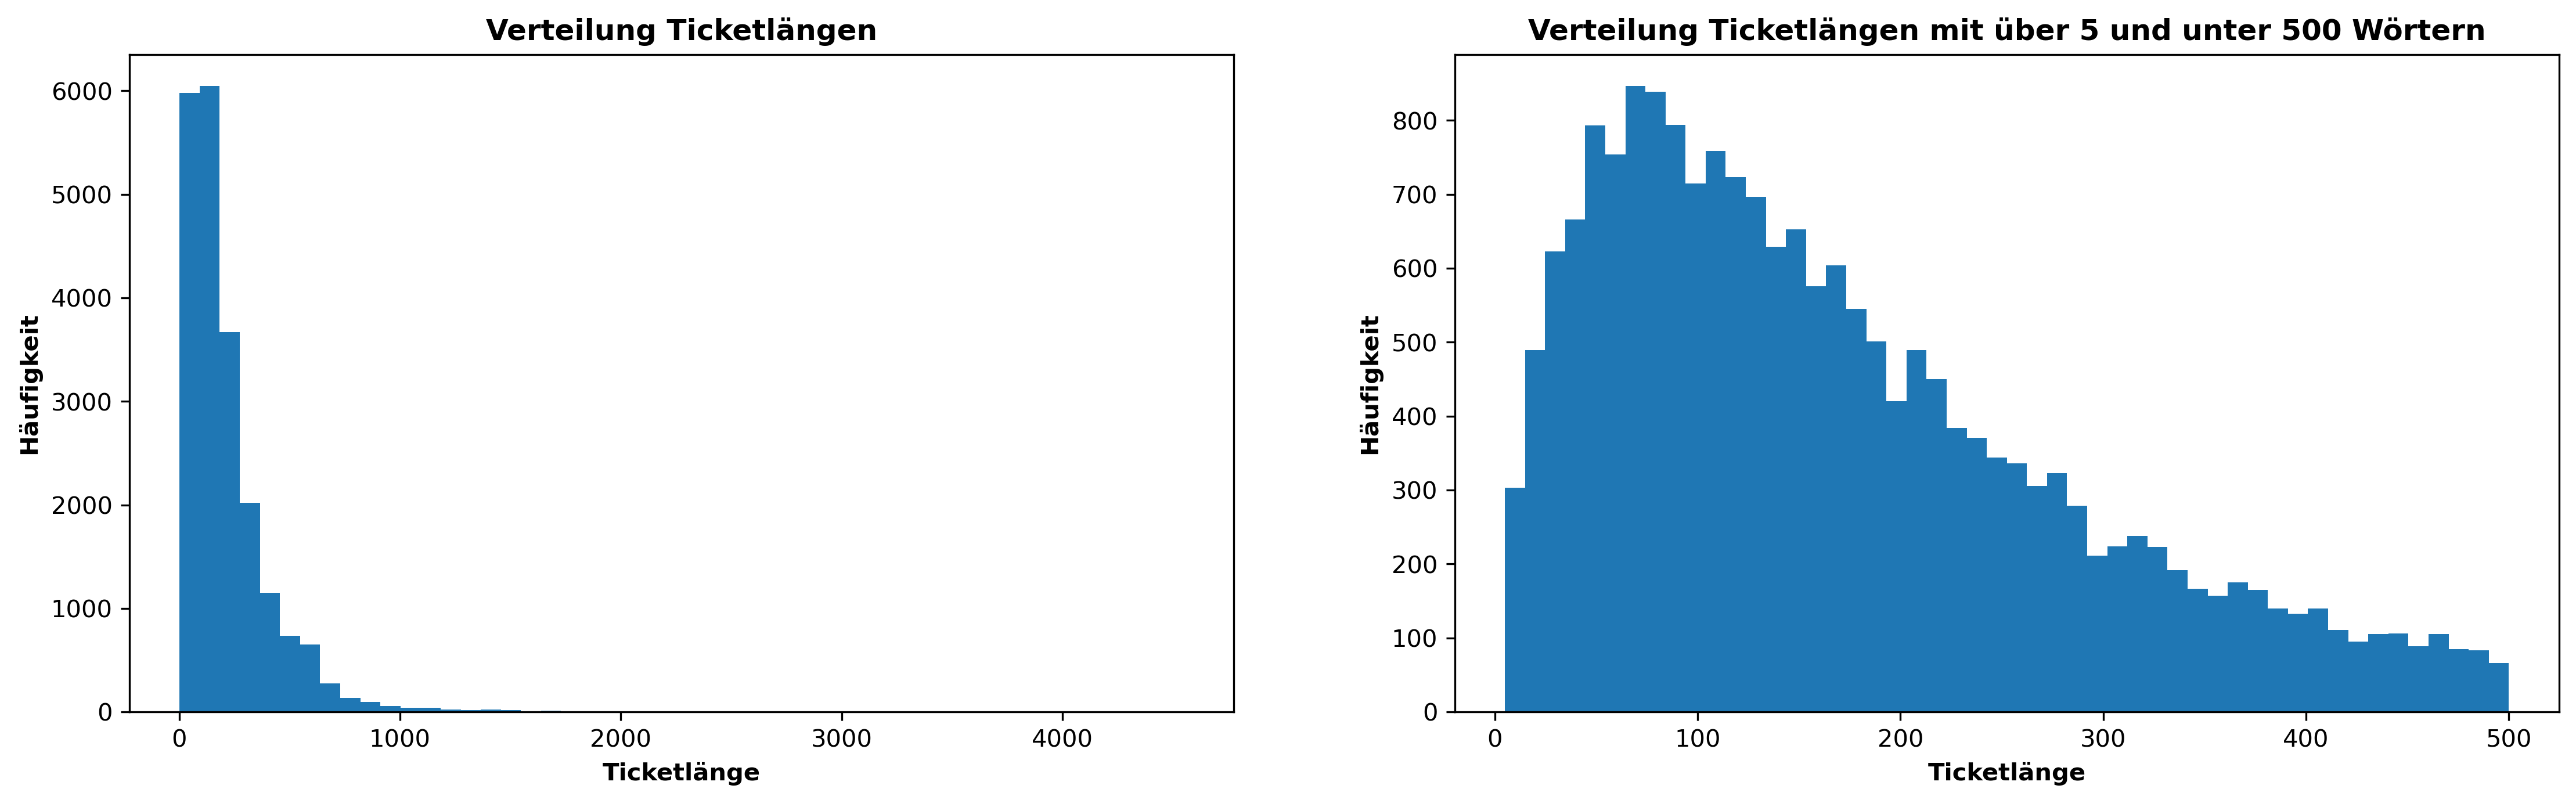

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 5))

ax1.hist(ticket_df.Länge, bins=50)
ax2.hist([l for l in ticket_df.Länge if (l > 4) and (l < 501)], bins=50)

ax1.set_title('Verteilung Ticketlängen', fontweight='bold')
ax1.set_xlabel('Ticketlänge', fontweight='bold')
ax1.set_ylabel('Häufigkeit', fontweight='bold')

ax2.set_title('Verteilung Ticketlängen mit über 5 und unter 500 Wörtern', fontweight='bold')
ax2.set_xlabel('Ticketlänge', fontweight='bold')
ax2.set_ylabel('Häufigkeit', fontweight='bold')

fig.savefig('pictures/ticketlength_histo_finance.png', dpi=600)
plt.show()

### Statistische Werte ausgeben

In [16]:
describe_df = ticket_df['Länge'].describe()
print(f"Die minimale Anzahl an Wörtern beträgt: {describe_df.loc['min']}")
print(f"Die durchschnittliche Anzahl an Wörtnern beträgt: {describe_df.loc['mean']}")
print(f"Die mediane Anzahl an Wörtern beträgt: {describe_df.loc['50%']}")
print(f"Die maximale Anzahl an Wörtern beträgt: {describe_df.loc['max']}")

Die minimale Anzahl an Wörtern beträgt: 2.0
Die durchschnittliche Anzahl an Wörtnern beträgt: 220.14194191343964
Die mediane Anzahl an Wörtern beträgt: 157.0
Die maximale Anzahl an Wörtern beträgt: 4549.0


In [17]:
ticket_df = ticket_df[(ticket_df.Länge >= 5) & (ticket_df.Länge <= 500)]
ticket_df

,Meldung,Ticketart,Meldung_cleaned,Meldung_BERT,Länge
0,Good morning my name is XXXX XXXX and I apprec...,0,good morning my name is and appreciate it if y...,good morning my name is and appreciate it if y...,75
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1,i upgraded my card in and was told by the agen...,i upgraded my card in and was told by the agen...,56
2,Chase Card was reported on XX/XX/2019. However...,1,chase card was reported on however fraudulent ...,chase card was reported on however fraudulent ...,31
3,"On XX/XX/2018, while trying to book a XXXX XX...",1,on while trying to book ticket came across an ...,on while trying to book ticket came across an ...,240
4,my grand son give me check for {$1600.00} i de...,0,my grand son give me check for deposit it into...,my grand son give me check for deposit it into...,88
...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,1,after being chase card customer for well over ...,after being chase card customer for well over ...,115
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",3,on wednesday called chas my visa credit card p...,on wednesday called chas my visa credit card p...,344
21069,I am not familiar with XXXX pay and did not un...,3,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,385
21070,I have had flawless credit for 30 yrs. I've ha...,4,i have had flawless credit for yrs ve had chas...,i have had flawless credit for yrs ve had chas...,337


### Vokabular vor Lemmatisierung zählen

In [18]:
voc_list = []

for index, row in ticket_df.iterrows():
    meldung_tokens = row['Meldung_cleaned'].split()
    voc_list.extend(meldung_tokens)

unique_tokens = set(voc_list)
count_voc = len(unique_tokens)
count_voc

22973

### Stopp-Wörter aus Meldung_cleaned entfernen

In [19]:
ticket_df['Meldung_cleaned'] = ticket_df['Meldung_cleaned'].apply(remove_stop_words)

### Meldung_lemmatized setzen

In [20]:
ticket_df['Meldung_lemmatized'] = ''

for index, row in ticket_df.iterrows():
    try:
        meldung = row['Meldung_cleaned']
        meldung_lemmatized = lemmatize_text_spacy(meldung)
    except:
        ticket_df.at[index, 'Meldung_lemmatized'] = ''
    else:
        ticket_df.at[index, 'Meldung_lemmatized'] = meldung_lemmatized

### Vokabular nach Lemmatisierung zählen

In [21]:
voc_list_lemma = []

for index, row in ticket_df.iterrows():
    meldung_tokens_lemma = row['Meldung_lemmatized'].split()
    voc_list_lemma.extend(meldung_tokens_lemma)

unique_tokens_lemma = set(voc_list_lemma)
count_voc_lemma = len(unique_tokens_lemma)
count_voc_lemma

18696

### Alle leeren Zeilen löschen

In [22]:
ticket_df.Meldung.replace(r'', np.nan, regex=True, inplace=True)
ticket_df = ticket_df[ticket_df.Meldung.notna()]

In [23]:
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19222 entries, 0 to 21071
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Meldung             19222 non-null  object
 1   Ticketart           19222 non-null  int64 
 2   Meldung_cleaned     19222 non-null  object
 3   Meldung_BERT        19222 non-null  object
 4   Länge               19222 non-null  int64 
 5   Meldung_lemmatized  19222 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.0+ MB


### Bereinigte Ticketdaten als Excel exportieren

In [24]:
ticket_df.to_excel("finance_tickets_cleaned_with_topics.xlsx")